Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import ResNet50, DenseNet121
import numpy as np
import matplotlib.pyplot as plt

from models import models

from sklearn import metrics

import os

c:\Users\joaov\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Dataset Configuration

In [2]:
batch_size = 16


train_ds = tf.keras.utils.image_dataset_from_directory(
    os.getcwd() + '/Train',
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode = 'categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.getcwd() + '/Test',
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode = 'categorical'
)

Found 587 files belonging to 7 classes.
Found 203 files belonging to 7 classes.


In [3]:
num_classes = len(train_ds.class_names)

Dataset Visualization

['Coffee', 'Corn', 'Eucalyptus', 'Goiaba', 'Orange', 'Soybean', 'Tomato']


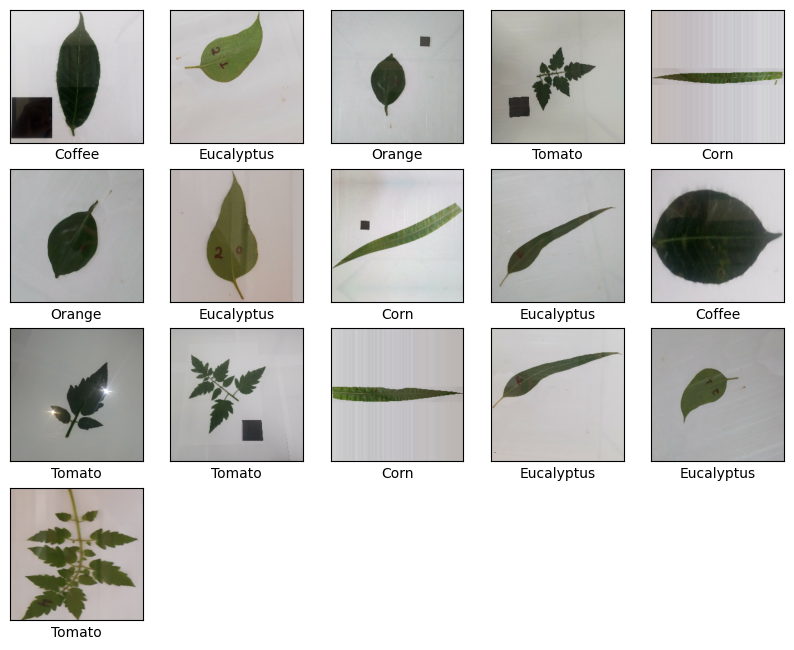

In [4]:
class_names = train_ds.class_names

print(class_names)

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(16):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.xlabel(class_names[tf.math.argmax(labels[i])])
  plt.show()

Normalizing Dataset

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Model

In [6]:
# model = tf.keras.applications.ResNet50(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(224,224,3),
#     pooling=None,
#     classes=1000
# )
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1000
)

base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs, name='resnet-finetuned')

if model is None:
    print("Model not found")
    exit()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


model.summary()

Model: "resnet-finetuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,693,063 (98.01 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

TRAINING

In [7]:
history = model.fit(train_ds, epochs=80)

train_acc = history.history["accuracy"]
train_loss = history.history["loss"]


Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 334ms/step - accuracy: 0.6197 - loss: 1.4968
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - accuracy: 0.9509 - loss: 0.1557
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step - accuracy: 0.9400 - loss: 0.1563
Epoch 4/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 346ms/step - accuracy: 0.9433 - loss: 0.1999
Epoch 5/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 358ms/step - accuracy: 0.9745 - loss: 0.0711
Epoch 6/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - accuracy: 0.9777 - loss: 0.0597
Epoch 7/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - accuracy: 0.9992 - loss: 0.0147
Epoch 8/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.9898 - loss: 0.0173
Epoch 9/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - accuracy: 0.9959 - loss: 0.0313
Epoch 10/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 335ms/step - accuracy: 0.9917 - loss: 0.0146
Epoch 11/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - accuracy: 1.0000 - loss: 0.0063
Epoch 12/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 12

Testing

In [8]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

print('\nTest accuracy:', test_acc)

# write loss and accuracy to file
f = open("output/acc_loss.txt", "a")
f.write(model.name + " " + str(test_loss) + " ")
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

def class_accuracy(y_true, y_pred, class_label):
    indices = y_true == class_label
    return metrics.accuracy_score(y_true[indices], y_pred[indices])

accuracies = {}
for class_label in range(num_classes):
    acc = class_accuracy(y_true, y_pred, class_label)
    accuracies[class_label] = acc

for class_label in accuracies:
    f.write(str(accuracies[class_label]) + " ")

f.write(str(test_acc) + "\n")
f.close()

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.9553 - loss: 0.4655

Test accuracy: 0.9408866763114929
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 348ms/step


Plotting

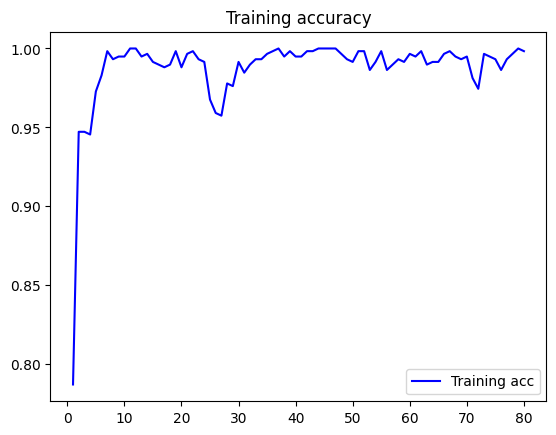

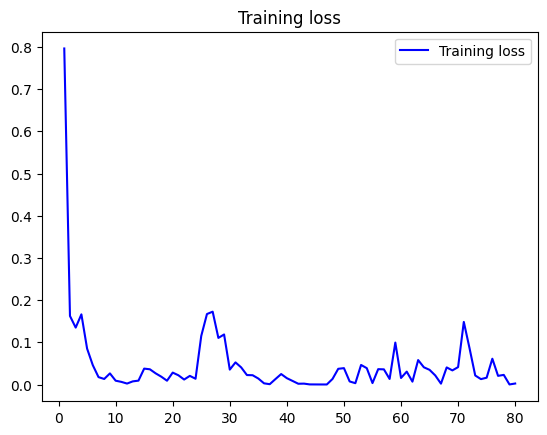

In [9]:
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.savefig("output/" + model.name + "_acc.png")
plt.figure()

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.savefig("output/" + model.name + "_loss.png")

plt.show()

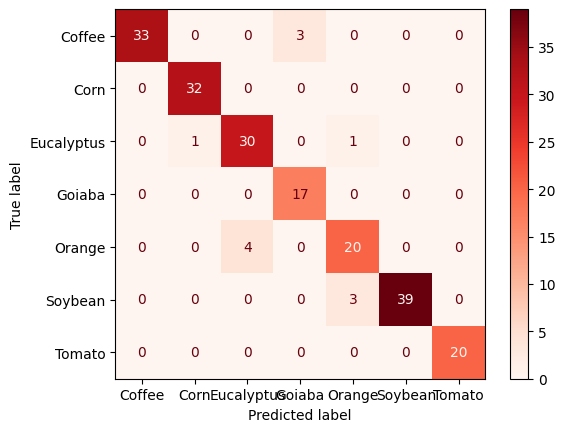

In [10]:
# probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
# predictions = probability_model.predict(test_ds)

predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x, verbose=0), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])


# confusion matrix
confusion_matrix = metrics.confusion_matrix(labels, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=class_names).plot(cmap=plt.cm.Reds)

cm_display.figure_.savefig("output/" + model.name + "_confusion_matrix.png")